# 1. Representación del Robot: Teoría de Estados

### Definición de Estado ($x_t$)
El estado $x_t$ es una representación cuantificable del robot y su entorno en un instante $t$. Para que un vehículo autónomo opere eficazmente, esta representación debe cumplir con cuatro cualidades fundamentales:

1.  **Suficiente:** Contiene *toda* la información requerida para la toma de decisiones.
2.  **Necesario (Minimalista):** Excluye datos irrelevantes para reducir la dimensionalidad.
3.  **Eficiente:** Debe ser computable en tiempo real (baja latencia).
4.  **Generalizable:** Robusto ante variaciones ambientales (iluminación, clima).

---

### La Propiedad de Markov
En el contexto de localización y control, el historial completo de sensores ($z_{0:t}$) y comandos ($u_{0:t}$) crece indefinidamente, haciendo inviable su procesamiento directo.

La **Suposición de Markov** establece que el estado futuro es condicionalmente independiente del pasado, dado el estado actual.

**Modelo Probabilístico de Transición:**

$$P(x_{t+1} | x_t, u_t)$$

Esto implica que el estado actual $x_t$ es un **estadístico suficiente** de toda la historia pasada.



## 2. Pose del Robot ($q_t$)

La "pose" define la ubicación y orientación del robot (sistema de coordenadas del cuerpo/body) respecto a un marco de referencia global (mundo/fixed).

En un entorno 2D, la pose se representa como un vector:

$$q_t = [x_t, y_t, \theta_t]^T$$

- **Posición:** $(x_t, y_t)$
    
- **Orientación:** $\theta_t$
    
![Pose del Robot](imagenes/Pasted%20image%2020260208173110.png)


## 3. Marcos de Referencia en $\mathbb{R}^2$

Para trabajar con Duckiebots, manejamos principalmente dos marcos:

- **World Frame ($W$):** Coordenadas globales $(x^w, y^w)$ con origen en el mundo.
    
- **Robot Frame ($A$):** Coordenadas locales $(x^r, y^r)$ con origen en el centro del robot, con una orientación $\theta$ respecto al eje $x^w$.
    
<img src="imagenes/Pasted image 20260208173338.png" width="500">

In [1]:
import numpy as np
# Importamos nuestra función de visualización desde el archivo externo
from utils import visualizar_pose


Vector de Pose q_t: [1.5, 1.0, 0.79]


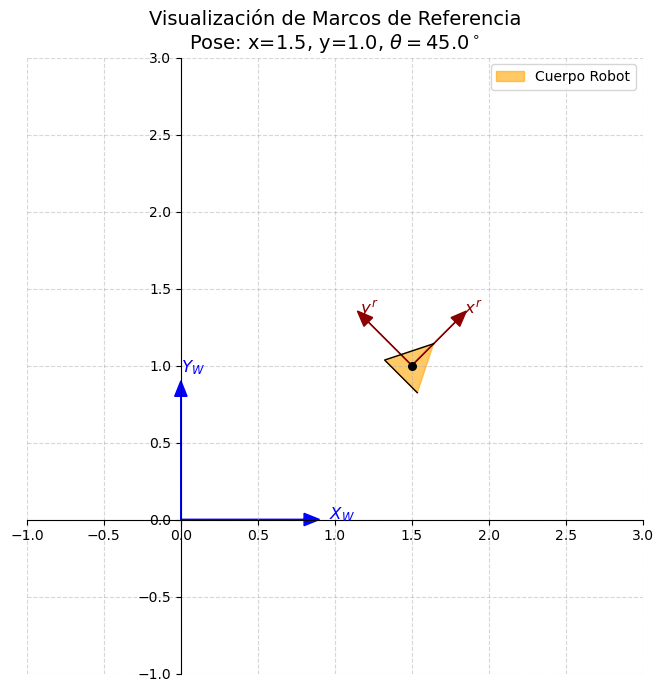

In [2]:
# --- DEFINICIÓN DE LA POSE ---
# El vector de estado q_t = [x, y, theta]

x_t = 1.5          # Traslación en X (metros)
y_t = 1.0          # Traslación en Y (metros)
theta_t = np.pi/4  # Rotación (45 grados en radianes)

print(f"Vector de Pose q_t: [{x_t}, {y_t}, {theta_t:.2f}]")

# --- VISUALIZACIÓN ---
visualizar_pose(x_t, y_t, theta_t)

## 4. Movimiento entre Marcos de Referencia

<img src="imagenes/Pasted image 20260208173511.png" width="500">


### Traslaciones de Puntos (Enfoque Vectorial)

Si queremos conocer la posición de un objeto $D$ (un patito) en el mundo, conociendo su posición relativa al robot:

$$A^w = \begin{bmatrix} x_A \\ y_A \end{bmatrix}, \quad D^r = \begin{bmatrix} x_D \\ y_D \end{bmatrix}$$

<img src="imagenes/Pasted image 20260208173710.png" width="500">
La posición de $D$ en el marco del mundo es la suma vectorial:

$$\begin{bmatrix} x_D^w \\ y_D^w \end{bmatrix} = \begin{bmatrix} x_D \\ y_D \end{bmatrix} + \begin{bmatrix} x_A \\ y_A \end{bmatrix} = \begin{bmatrix} x_D + x_A \\ y_D + y_A \end{bmatrix}$$

### Método 2: El Estándar en Robótica (Matrices Homogéneas)

Para unificar traslación y rotación en una sola operación matemática (multiplicación), añadimos una dimensión extra (un **1** al final).

$$\begin{bmatrix} x_D^w \\ y_D^w \\ 1 \end{bmatrix} = \underbrace{ \begin{bmatrix} 1 & 0 & x_A \\ 0 & 1 & y_A \\ 0 & 0 & 1 \end{bmatrix} }_{\text{Matriz de Traslación } T} \cdot \begin{bmatrix} x_D \\ y_D \\ 1 \end{bmatrix}$$
<img src="imagenes/Pasted image 20260208173832.png" width="500">



---


In [3]:
import numpy as np

# 1. Definimos las coordenadas del ejemplo
Posicion_Robot_A = np.array([2, 2])  # El robot está en x=2, y=2
Pato_Visto_D     = np.array([1, 1])  # El pato está a 1m en X y 1m en Y (relativo)

# --- MÉTODO 1: Suma simple (Intuición) ---
Pato_Global_Suma = Posicion_Robot_A + Pato_Visto_D
print(f"Posición Global (Suma simple): {Pato_Global_Suma}")

# --- MÉTODO 2: Matriz Homogénea (Estándar Robótico) ---
# Creamos la Matriz de Traslación de 3x3
# Observa cómo la posición del robot (2, 2) va en la última columna
T = np.array([
    [1, 0, 2],  # x del robot
    [0, 1, 2],  # y del robot
    [0, 0, 1]
])

# Convertimos el vector del pato a coordenadas homogéneas (agregando un 1)
Pato_Homogeneo = np.array([1, 1, 1])

# ¡Magia! La multiplicación hace la suma
Resultado_Homogeneo = T @ Pato_Homogeneo

print(f"Posición Global (Con Matriz):  {Resultado_Homogeneo[:2]}")

Posición Global (Suma simple): [3 3]
Posición Global (Con Matriz):  [3 3]



## 5. Rotaciones

### Coordenadas Polares en 2D

A veces es más útil representar la posición del objetivo $D$ mediante distancia ($r$) y ángulo ($\alpha$):

- **Representación Cartesiana:** $D^w = \begin{bmatrix} x_D^w \\ y_D^w \end{bmatrix}$
    
- **Representación Polar:** $D^w = \vec{r} = (r, \alpha)$
    

Las fórmulas de conversión son:

$$x_D^w = r \cos \alpha$$

$$y_D^w = r \sin \alpha$$

### Matriz de Rotación $SO(2)$

Las rotaciones se representan mediante una matriz $R_\theta$ que pertenece al **Grupo Especial Ortogonal $SO(2)$**. Esta matriz tiene propiedades matemáticas importantes que garantizan que el robot no se "deforme" al girar:

$$R_{\theta} = \begin{bmatrix} \cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{bmatrix} \in SO(2)$$

- **Propiedad de Ortogonalidad:** La transpuesta es igual a su inversa ($R_{\theta}^T = R_{\theta}^{-1}$).
    
- **Determinante:** $\det(R_{\theta}) = 1$ para todo $\theta \in \mathbb{R}$.
    

### Cálculo de Posición Rotada

Cuando el marco del robot está rotado un ángulo $\theta$, la posición del punto $D$ respecto al marco rotado se calcula como:

$$\begin{bmatrix} x_D^r \\ y_D^r \end{bmatrix} = \begin{bmatrix} \cos \theta & \sin \theta \\ -\sin \theta & \cos \theta \end{bmatrix} \begin{bmatrix} x_D^w \\ y_D^w \end{bmatrix}$$

Equivalente a:

$$x_D^r = r \cos(\alpha - \theta) = x_D^w \cos \theta + y_D^w \sin \theta$$

$$y_D^r = r \sin(\alpha - \theta) = -x_D^w \sin \theta + y_D^w \cos \theta$$

<img src="imagenes/Pasted image 20260208174216.png" width="500">



## 5. Rotaciones Puras

Ahora imaginemos que el robot está en el origen $(0,0)$ pero **gira** su cuerpo un ángulo $\theta$.

Si hay un objeto fijo en el mundo... ¿dónde lo ve el robot desde su perspectiva?

### La Matriz de Rotación $R$ (Grupo $SO(2)$)

Para describir la orientación del robot, usamos la matriz de rotación estándar. Esta matriz pertenece al grupo **SO(2)** (Special Orthogonal), lo que significa que **gira vectores sin estirarlos ni deformarlos**.

$$R_{\theta} = \begin{bmatrix} \cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{bmatrix}$$

### El Truco de la Inversa: Mundo $\rightarrow$ Robot

Aquí viene la parte clave.

- Si queremos pasar un punto del Robot al Mundo, usamos $R$.
    
- Pero si queremos pasar un punto del **Mundo ($w$)** al marco del **Robot ($r$)**, necesitamos "deshacer" la rotación. Usamos la **inversa**, que para estas matrices es igual a la **transpuesta** ($R^T$).
    

Observen cómo cambian los signos de los senos respecto a la matriz de arriba:

$$\underbrace{\begin{bmatrix} x_D^r \\ y_D^r \end{bmatrix}}_{\text{Visto por Robot}} = \underbrace{\begin{bmatrix} \cos \theta & \sin \theta \\ -\sin \theta & \cos \theta \end{bmatrix}}_{R^T (\text{Inversa})} \underbrace{\begin{bmatrix} x_D^w \\ y_D^w \end{bmatrix}}_{\text{En el Mundo}}$$

Equivalente a:

$$x_D^r = r \cos(\alpha - \theta) = x_D^w \cos \theta + y_D^w \sin \theta$$

$$y_D^r = r \sin(\alpha - \theta) = -x_D^w \sin \theta + y_D^w \cos \theta$$

<img src="imagenes/Pasted image 20260208174216.png" width="500">



Posición Real en el Mundo (Azul): [2. 1.]
Posición Vista por Robot  (Rojo): [ 2.12 -0.71]


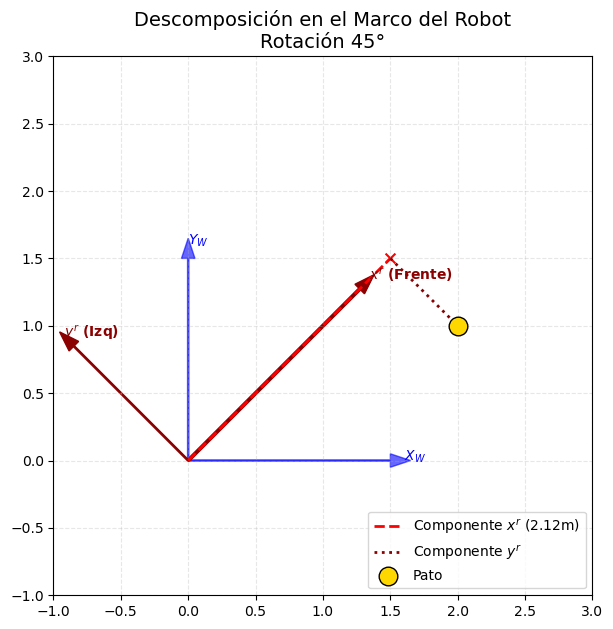

In [4]:
import numpy as np
# Si usas la magia de autoreload no necesitas reiniciar kernel
%load_ext autoreload
%autoreload 2
from utils import visualizar_rotacion_simple

# 1. CONFIGURACIÓN
theta = np.radians(45)        # 45 grados
Pato_W = np.array([2.0, 1.0]) # Pato en (2, 1) del Mundo

# 2. CÁLCULO MATEMÁTICO (Recuperamos esta parte)
c, s = np.cos(theta), np.sin(theta)
R = np.array([
    [c, -s],
    [s,  c]
])

# Calculamos la posición vista por el robot usando la TRANSPUESTA
Pato_R = R.T @ Pato_W

# 3. RESULTADOS NUMÉRICOS
print(f"Posición Real en el Mundo (Azul): {Pato_W}")
print(f"Posición Vista por Robot  (Rojo): {np.round(Pato_R, 2)}")

# 4. VISUALIZACIÓN GRÁFICA
visualizar_rotacion_simple(Pato_W, theta)

## 6. Transformación Completa: Rotación + Traslación ($SE(2)$)

Cuando el robot tiene tanto una posición $(x_A, y_A)$ como una orientación $\theta$ respecto al mundo, combinamos ambas operaciones.

**Desglose:**

- **Rotación Pura:** $D^a = R_\theta D^r$
    
- **Traslación Pura:** $D^w = T D^a$
    

Utilizamos una matriz de transformación del **Grupo Especial Euclidiano $SE(2)$**. Esta matriz permite pasar un punto $D$ del marco del robot ($D^r$) al marco del mundo ($D^w$) en una sola operación de multiplicación matricial:

$$D^w = T R_{\theta} D^r = \begin{bmatrix} \cos \theta & -\sin \theta & x_A \\ \sin \theta & \cos \theta & y_A \\ 0 & 0 & 1 \end{bmatrix} D^r$$


<img src="imagenes/Pasted image 20260208174338.png" width="500">

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Matriz de Transformación SE(2):
[[ 0.71 -0.71  2.  ]
 [ 0.71  0.71  2.  ]
 [ 0.    0.    1.  ]]

Ubicación Global Calculada: [3.41 3.41]


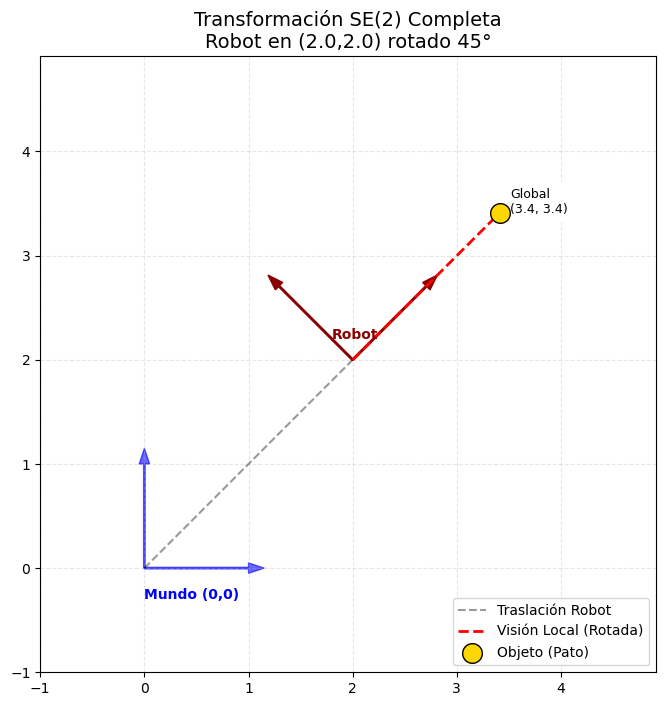

In [5]:
import numpy as np
# Si usas la magia de autoreload no necesitas reiniciar kernel
%load_ext autoreload
%autoreload 2
from utils import visualizar_transformacion_SE2

# 1. CONFIGURACIÓN DEL ESCENARIO
# El robot está en (2, 2) y girado 45 grados
x_robot, y_robot = 2.0, 2.0
theta = np.radians(45)

# El pato está 2 metros EN FRENTE del robot (eje X local)
# En local es (2, 0)
Pato_Local = np.array([2.0, 0.0, 1.0]) 

# 2. CÁLCULO MATRICIAL SE(2)
c, s = np.cos(theta), np.sin(theta)

# Matriz Homogénea 3x3
T_SE2 = np.array([
    [c, -s, x_robot],  # Rotación y Traslación X
    [s,  c, y_robot],  # Rotación y Traslación Y
    [0,  0,    1   ]
])

# Cálculo de la posición Global
Pato_Global = T_SE2 @ Pato_Local

# 3. RESULTADOS
print(f"Matriz de Transformación SE(2):\n{np.round(T_SE2, 2)}")
print(f"\nUbicación Global Calculada: {np.round(Pato_Global[:2], 2)}")

# 4. VISUALIZACIÓN
# Le pasamos la pose del robot y donde ve al pato localmente
visualizar_transformacion_SE2([x_robot, y_robot, theta], Pato_Local)

## 7. El Camino de Ida y Vuelta: Directa vs Inversa

En robótica, siempre nos hacemos dos preguntas diferentes dependiendo de la tarea:

### Caso A: Percibir (Sensing) $\rightarrow$ Usamos $T$

El robot ve un obstáculo con su cámara. Sabe dónde está el obstáculo respecto a él (local), pero necesita ponerlo en el mapa compartido (global).

$$P_{global} = T \cdot P_{local}$$

### Caso B: Navegar (Control) $\rightarrow$ Usamos $T^{-1}$

Queremos que el robot vaya a una estación de carga que está en el mapa en $(5,5)$. El robot necesita saber: _"¿Cuántos metros avanzo y cuánto giro para llegar?"_. Necesitamos convertir el punto global a coordenadas locales.

$$P_{local} = T^{-1} \cdot P_{global}$$

> **Nota:** La inversa de una matriz de transformación ($T^{-1}$) "deshace" la rotación y la traslación, llevando puntos del mundo al sistema de referencia del robot.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Meta en el Mapa: [4. 4.]
Para el Robot, la meta está a: 
 -> 2.83 metros ADELANTE
 -> 0.00 metros al LADO


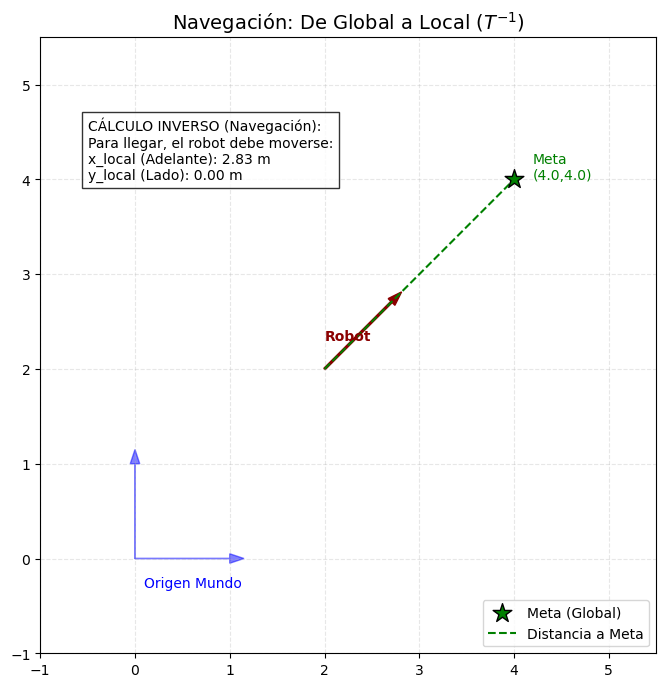

In [6]:
import numpy as np
%load_ext autoreload
%autoreload 2
from utils import visualizar_inversa

# 1. ESCENARIO DE NAVEGACIÓN
# El robot está en (2, 2) mirando a 45 grados
x_r, y_r, theta = 2.0, 2.0, np.radians(45)

# Queremos ir a una META en el mapa global (ej. coordenadas (4, 4))
Meta_Global = np.array([4.0, 4.0, 1.0]) # Homogéneo

# 2. MATRIZ DE TRANSFORMACIÓN (T)
c, s = np.cos(theta), np.sin(theta)
T = np.array([
    [c, -s, x_r],
    [s,  c, y_r],
    [0,  0, 1  ]
])

# 3. CÁLCULO INVERSO (Para Navegar)
# Usamos la inversa para traer el punto global al marco local
T_inv = np.linalg.inv(T)
Meta_Local = T_inv @ Meta_Global

print(f"Meta en el Mapa: {Meta_Global[:2]}")
print(f"Para el Robot, la meta está a: \n -> {Meta_Local[0]:.2f} metros ADELANTE")
print(f" -> {Meta_Local[1]:.2f} metros al LADO")

# 4. VISUALIZACIÓN
visualizar_inversa([x_r, y_r, theta], Meta_Global)

## 📝 Puntos Clave para Llevar (Take Away Points)

1.  **La elección de la representación** depende de la tarea (para navegar, necesitamos pose).
2.  Las **Variables de Estado ($x_t$)** codifican toda la información del mundo en el tiempo $t$.
3.  Los estados que cumplen la **Propiedad de Markov** son computacionalmente eficientes.
4.  La **Pose** (posición + orientación) es un estado ideal para robots móviles.
5.  Los desplazamientos planares entre marcos de referencia se expresan elegantemente como **multiplicaciones de matrices** gracias a la estructura del grupo **Especial Euclidiano $SE(2)$**.